In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path
file_path = '../data/hurdat2_1851_2023.txt'

# Initialize variables
cyclone_data = []
current_cyclone = None

# Function to convert latitude and longitude to float
def convert_lat_lon(value):
    if 'N' in value or 'E' in value:
        return float(value[:-1])
    elif 'S' in value or 'W' in value:
        return -float(value[:-1])

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Check if the line starts with 'AL' indicating a new cyclone
        if line.startswith('AL'):
            if current_cyclone is not None:
                cyclone_data.append(current_cyclone)
            current_cyclone = {'header': line.strip(), 'data': []}
        else:
            if current_cyclone is not None:
                current_cyclone['data'].append(line.strip().split(','))

# Append the last cyclone
if current_cyclone is not None:
    cyclone_data.append(current_cyclone)

# Process each cyclone's data
all_cyclone_dfs = []
for cyclone in cyclone_data:
    df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
                                                'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                                                'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'maxwnd'])
    # Convert data types where necessary
    df['Date'] = df['Date'].astype(str)
    df['Time'] = df['Time'].astype(str)
    df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
    df['Longitude'] = df['Longitude'].apply(convert_lat_lon)
    df['WindSpeed'] = df['WindSpeed'].astype(int)
    df['Pressure'] = df['Pressure'].astype(int)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
    df.set_index('Datetime', inplace=True)
    df['Cyclone'] = cyclone['header']  # Add a column for the cyclone identifier
    all_cyclone_dfs.append(df)

# Concatenate all cyclone dataframes into a single dataframe
all_data = pd.concat(all_cyclone_dfs)

# Move the Cyclone column to the first position
columns = ['Cyclone'] + [col for col in all_data.columns if col != 'Cyclone']
all_data = all_data[columns]

# Define the latitude and longitude range for filtering
min_lat, max_lat = 27.5, 29.4
min_lon, max_lon = -81.5, -78.8

# Filter the data based on the specified latitude and longitude range
filtered_data = all_data[(all_data['Latitude'] >= min_lat) & (all_data['Latitude'] <= max_lat) &
                         (all_data['Longitude'] >= min_lon) & (all_data['Longitude'] <= max_lon)]

# Define the priority order for statuses
priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
filtered_data['StatusPriority'] = filtered_data['Status'].map(priority_order).fillna(4)

# Sort by Cyclone and StatusPriority
filtered_data.sort_values(by=['Cyclone', 'StatusPriority'], inplace=True)


In [2]:
aoi_months = filtered_data

In [3]:
aoi_months['Month'] = aoi_months.index.month

/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_30605/1425907753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi_months['Month'] = aoi_months.index.month


In [4]:
aoi_months = aoi_months.groupby('Month')['Cyclone'].nunique()

In [5]:
aoi_months.index = ['May', 'June', 'July', 'August', 'September',
               'October', 'November', 'December']

Text(12, 2, 'Highest Threat is Aug to Oct')

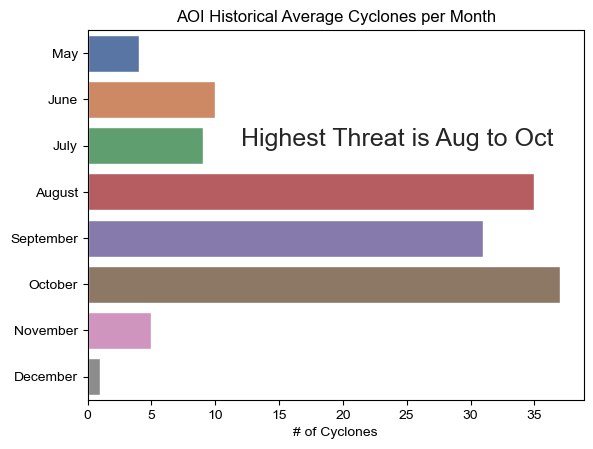

In [6]:
fig, ax = plt.subplots()
sns.set_theme(style='whitegrid')
sns.barplot(x=aoi_months, y=aoi_months.index)
ax.set_title('AOI Historical Average Cyclones per Month')
ax.set_xlabel('# of Cyclones')
ax.text(12, 2, 'Highest Threat is Aug to Oct', fontsize=18)

In [37]:
aoi_months

May           4
June         10
July          9
August       35
September    31
October      37
November      5
December      1
Name: Cyclone, dtype: int64

In [9]:
filtered_data

,Cyclone,Date,Time,Record,Status,Latitude,Longitude,WindSpeed,Pressure,Rad_34_NE,...,Rad_50_SE,Rad_50_SW,Rad_50_NW,Rad_64_NE,Rad_64_SE,Rad_64_SW,Rad_64_NW,maxwnd,StatusPriority,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
1910-08-26 12:00:00,"AL011910, UNNAMED, 27,",19100826,1200,,TD,27.5,-79.0,30,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,8
1910-08-26 18:00:00,"AL011910, UNNAMED, 27,",19100826,1800,,TD,28.4,-79.0,30,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,8
1914-09-16 18:00:00,"AL011914, UNNAMED, 19,",19140916,1800,,TS,29.1,-79.2,55,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,9
1915-08-01 00:00:00,"AL011915, UNNAMED, 22,",19150801,0000,,TS,27.9,-79.2,55,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,8
1915-08-01 06:00:00,"AL011915, UNNAMED, 22,",19150801,0600,,TS,28.1,-79.8,60,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969-10-03 18:00:00,"AL241969, JENNY, 16,",19691003,1800,,TD,28.9,-80.6,30,1004,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,10
1969-10-04 00:00:00,"AL241969, JENNY, 16,",19691004,0000,,TD,29.1,-80.9,25,1005,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,10
1969-10-04 06:00:00,"AL241969, JENNY, 16,",19691004,0600,,TD,29.1,-81.2,25,1008,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,10


In [65]:
filtered_data.describe()

,Latitude,Longitude,WindSpeed,Pressure,StatusPriority,Month
count,271.000000,271.000000,271.000000,271.000000,271.0,271.000000
mean,28.513653,-80.046863,50.036900,10.095941,4.0,8.450185
std,0.585123,0.848648,22.056294,999.889723,0.0,1.433821
min,27.500000,-81.500000,15.000000,-999.000000,4.0,5.000000
25%,28.000000,-80.750000,30.000000,-999.000000,4.0,8.000000
50%,28.500000,-80.100000,45.000000,943.000000,4.0,9.000000
75%,29.000000,-79.200000,60.000000,1002.000000,4.0,10.000000
max,29.400000,-78.800000,110.000000,1017.000000,4.0,12.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='WindSpeed', ylabel='Count'>

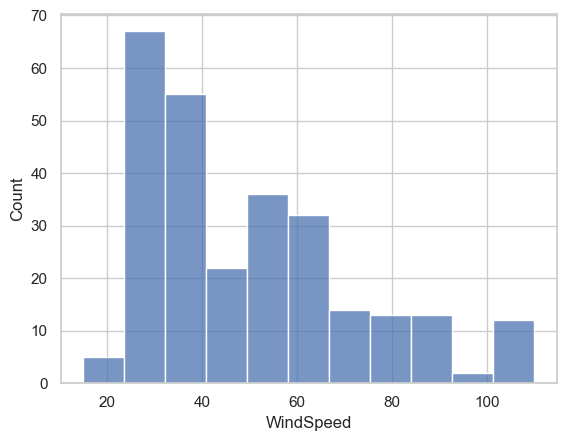

In [66]:
sns.histplot(filtered_data['WindSpeed'])

In [61]:
wnd_strength = filtered_data

In [ ]:
wnd_strength_2 = wnd_strength.groupby('')